Import packages, configure jupyter notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=FutureWarning)


Read in the data

In [93]:
data = pd.read_csv("https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv")

basics EDA

In [94]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 9 columns):
holiday                8573 non-null object
temp                   8573 non-null float64
rain_1h                8573 non-null float64
snow_1h                8573 non-null int64
clouds_all             8573 non-null int64
weather_main           8573 non-null object
weather_description    8573 non-null object
date_time              8573 non-null object
traffic_volume         8573 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 602.9+ KB


data looks quite clean with no null values

In [6]:
data.nunique()

holiday                  11
temp                   3651
rain_1h                  98
snow_1h                   1
clouds_all               50
weather_main             10
weather_description      33
date_time              7294
traffic_volume         4187
dtype: int64

In [7]:
data["snow_1h"].value_counts()

0    8573
Name: snow_1h, dtype: int64

there appears to be no snow, let's check if the temperature is too high for snow

In [8]:
def kelvin_to_celcius(kelvin):
    return kelvin-273.15

In [9]:
data["temp_celcius"] = data["temp"].apply(kelvin_to_celcius)

In [10]:
data.drop("temp", axis=1, inplace=True)

In [11]:
data["temp_celcius"].min()

-28.329999999999984

In [12]:
data["temp_celcius"].max()

35.09000000000003

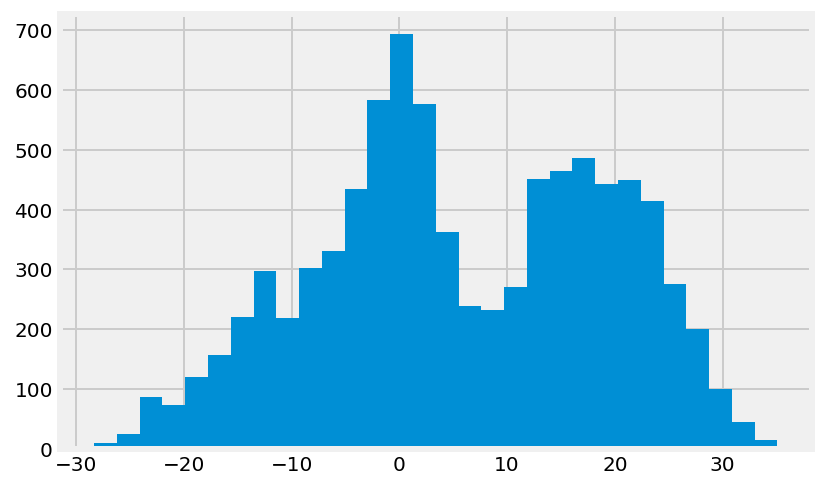

In [13]:
data["temp_celcius"].hist(bins=30)

there appears to be negative temperatures, but still now snow. Nonetheless the column is not very important because has no variance

In [14]:
data = data.drop(["snow_1h"], axis=1)

In [15]:
data.head()

,holiday,rain_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,temp_celcius
0,New Years Day,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,-9.66
1,None,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,-9.37
2,None,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,-8.99
3,None,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,-9.20
4,None,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,-9.50


Lets investigate the data_time column

In [16]:
data["date_time"] = pd.to_datetime(data["date_time"])

In [17]:
data["date_time"].min()

Timestamp('2013-01-01 00:00:00')

In [18]:
data["date_time"].max()

Timestamp('2013-12-31 23:00:00')

looks like we have 1 year of data

In [19]:
data["date"] = data["date_time"].apply(lambda x: datetime.strftime(x,"%Y-%m-%d"))
data["time"] = data["date_time"].apply(lambda x: datetime.strftime(x,"%H:%M"))

In [20]:
data["date"].value_counts()

2013-04-19    60
2013-12-03    56
2013-02-11    53
2013-04-12    52
2013-05-19    52
              ..
2013-10-01     2
2013-10-27     1
2013-09-01     1
2013-01-29     1
2013-08-31     1
Name: date, Length: 356, dtype: int64

looks like we have some missing days, not 365 for 2013

In [21]:
def get_all_dates(start, end):

    sdate = datetime.strptime(start,"%Y-%m-%d")   # start date
    edate = datetime.strptime(end,"%Y-%m-%d")   # end date

    delta = edate - sdate       # as timedelta

    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        yield(day.strftime("%Y-%m-%d"))

lets find the missing dates

In [22]:
all_dates_in_2013 = list(get_all_dates("2013-01-01","2013-12-31"))

In [23]:
all_dates = list(data["date"].unique())

In [24]:
missing_dates = [x for x in all_dates_in_2013 if x not in all_dates]

In [25]:
missing_dates

['2013-10-28',
 '2013-10-29',
 '2013-10-30',
 '2013-10-31',
 '2013-11-01',
 '2013-11-02',
 '2013-11-03',
 '2013-11-04',
 '2013-11-05']

looks like we have a bunch of data in end of oct to start of nov (9 days)

In [26]:
date_unique_time = data[["date","time"]].drop_duplicates().groupby("date").count()

In [27]:
date_unique_time["time"].value_counts()

24    135
23     59
22     37
21     18
15     13
17     12
20     10
19      9
18      9
16      9
12      9
14      7
11      5
1       5
13      4
10      3
9       3
8       3
6       3
7       1
3       1
2       1
Name: time, dtype: int64

In [28]:
date_unique_time["time"].value_counts().sum()-135

221

data is not very complete, with quite a number of dates (221) without complete data

In [29]:
datetime_count = data.groupby("date_time").count()

In [30]:
datetime_count = datetime_count.sort_values("holiday",ascending=False).reset_index()

In [31]:
datetime_count

,date_time,holiday,rain_1h,clouds_all,weather_main,weather_description,traffic_volume,temp_celcius,date,time
0,2013-05-19 10:00:00,6,6,6,6,6,6,6,6,6
1,2013-04-18 22:00:00,6,6,6,6,6,6,6,6,6
2,2013-12-16 10:00:00,5,5,5,5,5,5,5,5,5
3,2013-04-22 19:00:00,5,5,5,5,5,5,5,5,5
4,2013-05-20 17:00:00,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...
7289,2013-05-06 02:00:00,1,1,1,1,1,1,1,1,1
7290,2013-05-06 01:00:00,1,1,1,1,1,1,1,1,1
7291,2013-05-06 00:00:00,1,1,1,1,1,1,1,1,1
7292,2013-05-05 23:00:00,1,1,1,1,1,1,1,1,1


lets check out the dates with mulitpled datetime

In [32]:
datetime_count[datetime_count["holiday"]>1]

,date_time,holiday,rain_1h,clouds_all,weather_main,weather_description,traffic_volume,temp_celcius,date,time
0,2013-05-19 10:00:00,6,6,6,6,6,6,6,6,6
1,2013-04-18 22:00:00,6,6,6,6,6,6,6,6,6
2,2013-12-16 10:00:00,5,5,5,5,5,5,5,5,5
3,2013-04-22 19:00:00,5,5,5,5,5,5,5,5,5
4,2013-05-20 17:00:00,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...
869,2013-06-11 12:00:00,2,2,2,2,2,2,2,2,2
870,2013-06-11 11:00:00,2,2,2,2,2,2,2,2,2
871,2013-12-10 04:00:00,2,2,2,2,2,2,2,2,2
872,2013-06-11 08:00:00,2,2,2,2,2,2,2,2,2


about 874 records have repeated date_time

In [33]:
repeated_datetime = list(datetime_count[datetime_count["holiday"]>1]["date_time"])

In [34]:
repeated_records = data[data["date_time"].isin(repeated_datetime)]

In [35]:
repeated_records

,holiday,rain_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,temp_celcius,date,time
39,None,0.00,90,Snow,heavy snow,2013-01-02 15:00:00,4836,-11.54,2013-01-02,15:00
40,None,0.00,90,Mist,mist,2013-01-02 15:00:00,4836,-11.54,2013-01-02,15:00
41,None,0.00,90,Snow,heavy snow,2013-01-02 16:00:00,5597,-10.97,2013-01-02,16:00
42,None,0.00,90,Haze,haze,2013-01-02 16:00:00,5597,-10.97,2013-01-02,16:00
43,None,0.00,90,Snow,heavy snow,2013-01-02 17:00:00,5191,-10.61,2013-01-02,17:00
...,...,...,...,...,...,...,...,...,...,...
8534,None,0.00,90,Haze,haze,2013-12-30 10:00:00,3793,-19.81,2013-12-30,10:00
8539,None,0.76,90,Rain,light rain,2013-12-30 15:00:00,4233,-17.14,2013-12-30,15:00
8540,None,0.76,90,Snow,light snow,2013-12-30 15:00:00,4233,-17.14,2013-12-30,15:00
8541,None,0.25,90,Rain,light rain,2013-12-30 16:00:00,3938,-17.34,2013-12-30,16:00


Not sure why there are mulitiple records for the same time (about 25% of all the records). They dont appear to be pure duplicates, but it's worth noting for further investigations later

Lets investigate the non-numeric columns, holiday, weather_main, weather_description

In [36]:
non_numeric_columns = ["holiday", "weather_main", "weather_description"]

In [37]:
non_numeric_data = data[non_numeric_columns]

In [38]:
non_numeric_data["holiday"].value_counts()

None                    8563
Thanksgiving Day           1
Veterans Day               1
Independence Day           1
New Years Day              1
Memorial Day               1
State Fair                 1
Christmas Day              1
Columbus Day               1
Labor Day                  1
Washingtons Birthday       1
Name: holiday, dtype: int64

seems like mostly None, which we can convert to np.na, when building our models

In [39]:
non_numeric_data["weather_main"].value_counts()

Clouds          3136
Clear           2169
Mist            1034
Rain             889
Snow             674
Drizzle          230
Haze             201
Fog              123
Thunderstorm     114
Squall             3
Name: weather_main, dtype: int64

pretty good distribution of the data

In [40]:
non_numeric_data["weather_description"].value_counts()

sky is clear                           1494
broken clouds                          1194
overcast clouds                        1070
mist                                   1034
Sky is Clear                            675
light rain                              617
scattered clouds                        518
heavy snow                              397
few clouds                              354
moderate rain                           205
light snow                              202
haze                                    201
light intensity drizzle                 145
fog                                     123
drizzle                                  75
snow                                     71
proximity thunderstorm                   59
heavy intensity rain                     56
thunderstorm with heavy rain             17
thunderstorm with light rain             13
heavy intensity drizzle                  10
proximity thunderstorm with rain          9
very heavy rain                 

seems like there are too many combinations, not sure how useful this data would be for building models, without implementing indepth nlp, i will be dropping this column as well

In [41]:
data.drop("weather_description", axis=1, inplace=True)

In [42]:
data.head()

,holiday,rain_1h,clouds_all,weather_main,date_time,traffic_volume,temp_celcius,date,time
0,New Years Day,0.0,58,Clouds,2013-01-01 00:00:00,1439,-9.66,2013-01-01,00:00
1,None,0.0,40,Clouds,2013-01-01 01:00:00,1502,-9.37,2013-01-01,01:00
2,None,0.0,75,Snow,2013-01-01 02:00:00,933,-8.99,2013-01-01,02:00
3,None,0.0,90,Clouds,2013-01-01 03:00:00,576,-9.20,2013-01-01,03:00
4,None,0.0,90,Clouds,2013-01-01 04:00:00,372,-9.50,2013-01-01,04:00


lets plot temperature againste date, we expect the temperature to be related to the seasons

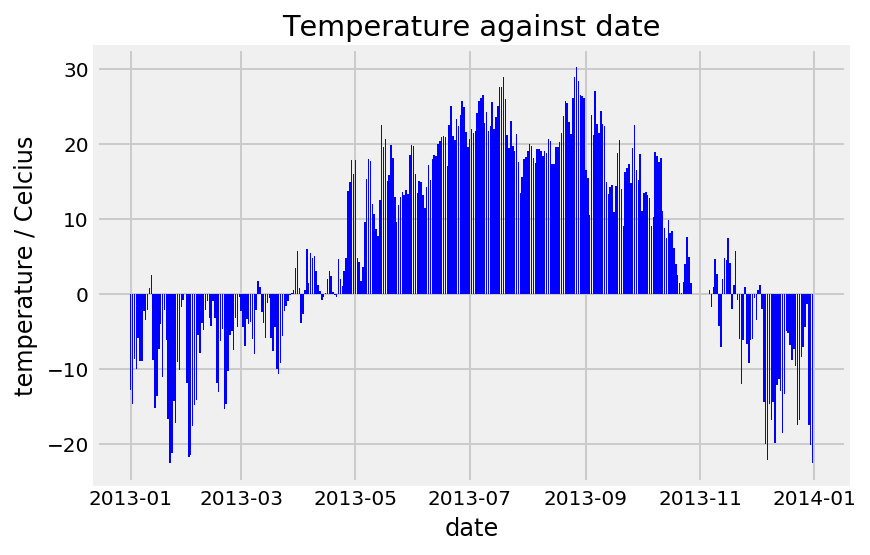

In [43]:
plot_temp_date = data[["temp_celcius","date"]].groupby("date").mean()
plot_temp_date.reset_index(inplace=True)
plot_temp_date["date"] = pd.to_datetime(plot_temp_date["date"])
plt.title("Temperature against date")
plt.xlabel("date")
plt.ylabel("temperature / Celcius")
plt.bar(plot_temp_date["date"], plot_temp_date["temp_celcius"], color="blue")
plt.show()

/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


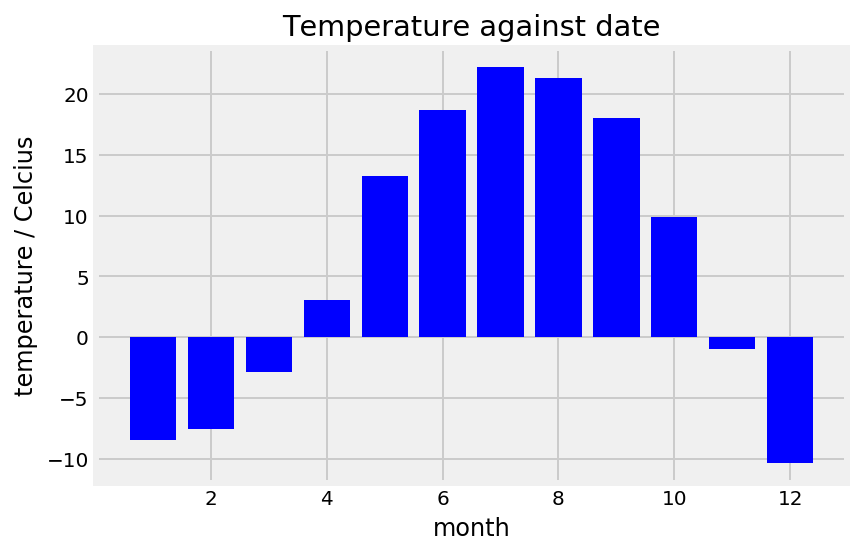

In [44]:
plot_temp_date = data[["temp_celcius","date"]]
plot_temp_date["date"] = pd.to_datetime(plot_temp_date["date"])
plot_temp_date["month"] = plot_temp_date["date"].apply(lambda x : x.month)
plot_temp_date = plot_temp_date[["month","temp_celcius"]].groupby("month").mean()
plot_temp_date.reset_index(inplace=True)
plt.title("Temperature against date")
plt.xlabel("month")
plt.ylabel("temperature / Celcius")
plt.bar(plot_temp_date["month"], plot_temp_date["temp_celcius"], color="blue")
plt.show()

seems pretty clear it's northern hemisphere city

lets plot temperature againste time, we expect the temperature to be related to the time

In [45]:
data.head()

,holiday,rain_1h,clouds_all,weather_main,date_time,traffic_volume,temp_celcius,date,time
0,New Years Day,0.0,58,Clouds,2013-01-01 00:00:00,1439,-9.66,2013-01-01,00:00
1,None,0.0,40,Clouds,2013-01-01 01:00:00,1502,-9.37,2013-01-01,01:00
2,None,0.0,75,Snow,2013-01-01 02:00:00,933,-8.99,2013-01-01,02:00
3,None,0.0,90,Clouds,2013-01-01 03:00:00,576,-9.20,2013-01-01,03:00
4,None,0.0,90,Clouds,2013-01-01 04:00:00,372,-9.50,2013-01-01,04:00


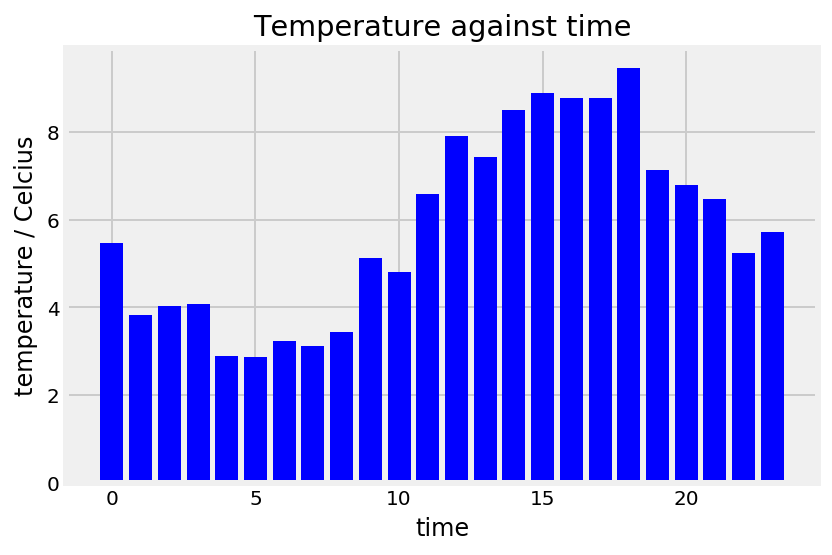

In [46]:
plot_temp_against_time = data[["time","temp_celcius"]].groupby("time").mean()
plot_temp_against_time.reset_index(inplace=True)
plot_temp_against_time["time"] = plot_temp_against_time["time"].apply(lambda x: int(x[:2]))
plt.title("Temperature against time")
plt.xlabel("time")
plt.ylabel("temperature / Celcius")
plt.bar(plot_temp_against_time["time"], plot_temp_against_time["temp_celcius"], color="blue")
plt.show()

Objective of the model is to predict the target column `traffic_volume`, to check relationship between traffic_volumn and other columns

analyse time against traffic volume

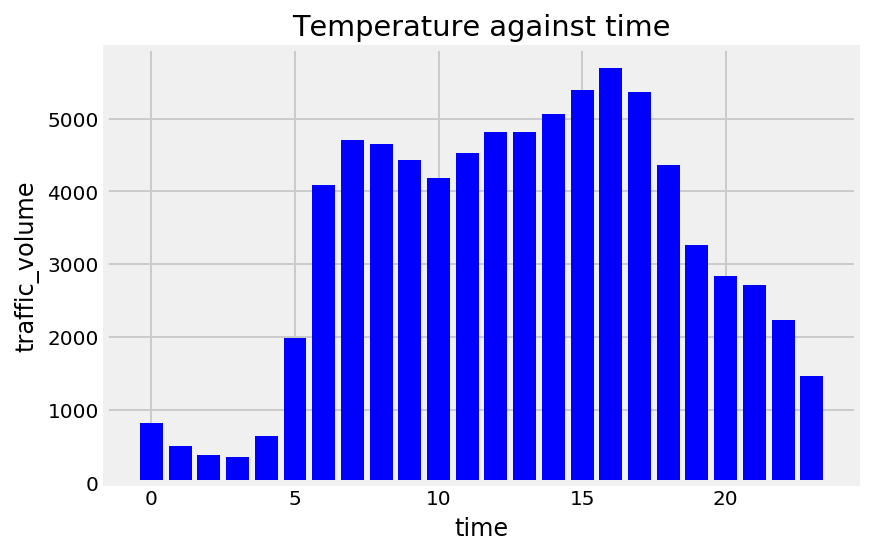

In [47]:
plot_traffic_against_time = data[["time","traffic_volume"]].groupby("time").mean()
plot_traffic_against_time.reset_index(inplace=True)
plot_traffic_against_time["time"] = plot_traffic_against_time["time"].apply(lambda x: int(x[:2]))
plt.title("Temperature against time")
plt.xlabel("time")
plt.ylabel("traffic_volume")
plt.bar(plot_traffic_against_time["time"], plot_traffic_against_time["traffic_volume"], color="blue")
plt.show()

You would expect that traffic would be high during certain peak periods, but traffic seems to be pretty stable (high) during the daty, and lower towards the night time

also the clock is quite cyclical, so the model has to account for that as well

let investigate traffic volume with the date of the year

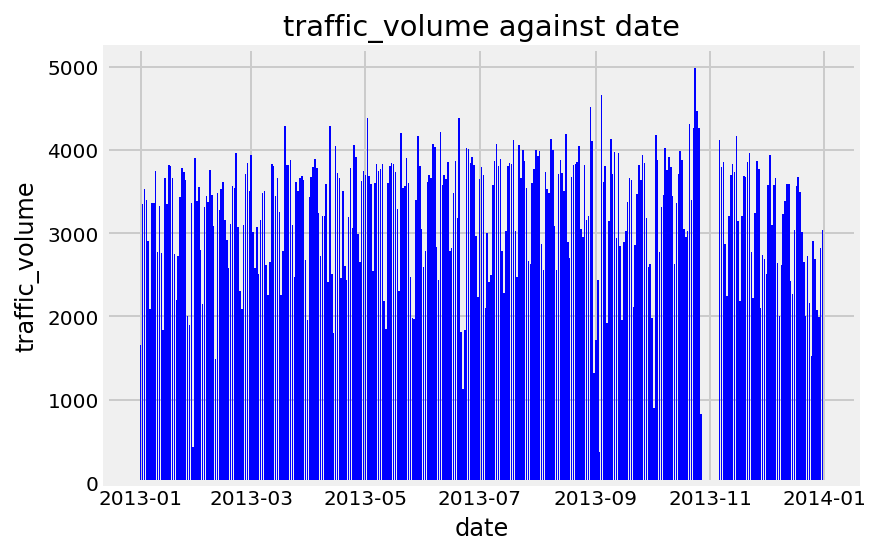

In [48]:
plot_traffic_date = data[["traffic_volume","date"]].groupby("date").mean()
plot_traffic_date.reset_index(inplace=True)
plot_traffic_date["date"] = pd.to_datetime(plot_traffic_date["date"])
plt.title("traffic_volume against date")
plt.xlabel("date")
plt.ylabel("traffic_volume")
plt.bar(plot_traffic_date["date"], plot_traffic_date["traffic_volume"], color="blue")
plt.show()

hard to tell, let's check it by month

/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


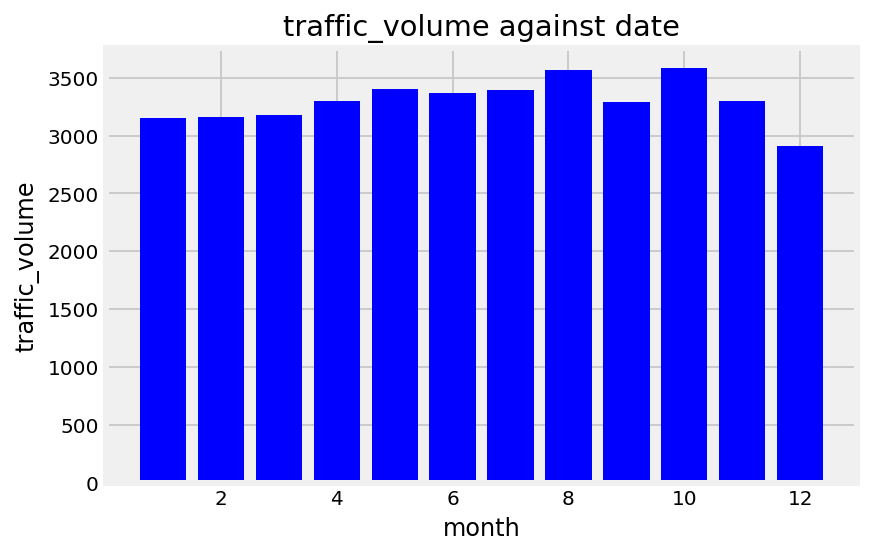

In [49]:
plot_traffic_date = data[["traffic_volume","date"]]
plot_traffic_date["date"] = pd.to_datetime(plot_traffic_date["date"])
plot_traffic_date["month"] = plot_traffic_date["date"].apply(lambda x : x.month)
plot_traffic_date = plot_traffic_date[["month","traffic_volume"]].groupby("month").mean()
plot_traffic_date.reset_index(inplace=True)
plt.title("traffic_volume against date")
plt.xlabel("month")
plt.ylabel("traffic_volume")
plt.bar(plot_traffic_date["month"], plot_traffic_date["traffic_volume"], color="blue")
plt.show()

looks pretty flat on the monthly basis

prepare data to build models

In [50]:
data.head()

,holiday,rain_1h,clouds_all,weather_main,date_time,traffic_volume,temp_celcius,date,time
0,New Years Day,0.0,58,Clouds,2013-01-01 00:00:00,1439,-9.66,2013-01-01,00:00
1,None,0.0,40,Clouds,2013-01-01 01:00:00,1502,-9.37,2013-01-01,01:00
2,None,0.0,75,Snow,2013-01-01 02:00:00,933,-8.99,2013-01-01,02:00
3,None,0.0,90,Clouds,2013-01-01 03:00:00,576,-9.20,2013-01-01,03:00
4,None,0.0,90,Clouds,2013-01-01 04:00:00,372,-9.50,2013-01-01,04:00


the holiday name is unimportant, so we shall convert it to binary, 1 for holiday, 0 for none

In [51]:
data["holiday"] = data["holiday"].apply(lambda x : 1 if x != "None" else 0)

In [52]:
weather = pd.get_dummies(data["weather_main"])

In [53]:
weather.head()

,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Snow,Squall,Thunderstorm
0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0


In [54]:
data = pd.concat([data,weather],axis=1)

In [55]:
data["time"] = data["time"].apply(lambda x: int(x[:2]))

In [56]:
time = pd.get_dummies(data["time"])
time.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
data = pd.concat([data,time],axis=1)

In [58]:
data.drop(["weather_main","date_time","date","time"],axis=1,inplace=True)

In [59]:
data.head()

,holiday,rain_1h,clouds_all,traffic_volume,temp_celcius,Clear,Clouds,Drizzle,Fog,Haze,...,14,15,16,17,18,19,20,21,22,23
0,1,0.0,58,1439,-9.66,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,40,1502,-9.37,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,75,933,-8.99,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,90,576,-9.20,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,90,372,-9.50,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 39 columns):
holiday           8573 non-null int64
rain_1h           8573 non-null float64
clouds_all        8573 non-null int64
traffic_volume    8573 non-null int64
temp_celcius      8573 non-null float64
Clear             8573 non-null uint8
Clouds            8573 non-null uint8
Drizzle           8573 non-null uint8
Fog               8573 non-null uint8
Haze              8573 non-null uint8
Mist              8573 non-null uint8
Rain              8573 non-null uint8
Snow              8573 non-null uint8
Squall            8573 non-null uint8
Thunderstorm      8573 non-null uint8
0                 8573 non-null uint8
1                 8573 non-null uint8
2                 8573 non-null uint8
3                 8573 non-null uint8
4                 8573 non-null uint8
5                 8573 non-null uint8
6                 8573 non-null uint8
7                 8573 non-null uint8
8              

looks like we have a purely numeric columns, we can start building our model

In [61]:
x_columns = [x for x in list(data.columns) if x != "traffic_volume"]

In [62]:
x = data[x_columns]
y = data["traffic_volume"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

Let's first determine the base case for the model, a simple mean of the traffic volume will be used for the base case

we will be using root mean square error to as a measure of the model's accuracy

In [63]:
print("mean: {}".format(y_train.mean()))
print("y_train.shape: {}".format(y_train.shape))
print("y_valid.shape: {}".format(y_valid.shape))

mean: 3280.576990376203
y_train.shape: (6858,)
y_valid.shape: (1715,)


In [64]:
y_train_pred = np.full((6858,), 3280.576990376203)
y_valid_pred = np.full((1715,), 3280.576990376203)

In [65]:
def calculate_rms(actual, predict):
    return sqrt(mean_squared_error(actual, predict))

In [66]:
base_rms_train = calculate_rms(y_train, y_train_pred)
base_rms_valid = calculate_rms(y_valid, y_valid_pred)
print(base_rms_train)
print(base_rms_valid)

2030.9409133606346
2017.272180580627


Lets attempt a linear regression model to improve the rms over the base case

In [67]:
linreg=LinearRegression()
linreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [68]:
y_train_pred.shape

(6858,)

In [69]:
y_train_pred = linreg.predict(x_train)
y_valid_pred = linreg.predict(x_valid)
linR_rms_train = calculate_rms(y_train, y_train_pred)
linR_rms_valid = calculate_rms(y_valid, y_valid_pred)
print(linR_rms_train)
print(linR_rms_valid)

960.2444578893146
943.6942855973754


1) Looks like there's quite an improvement of the RMS error when using linear regression, over a simple mean of the training data  
2) The variance between the train and validation rms is pretty small, thus we can assume that the model is not overfitting and has generalised pretty well  

overall pretty good result from a simple linear regression

Lets attempt a logistic regression model to improve the rms over the linear_regression case

In [70]:
logreg=LogisticRegression()
logreg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [71]:
y_train_pred = logreg.predict(x_train)
y_valid_pred = logreg.predict(x_valid)

In [72]:
lr_rms_train = calculate_rms(y_train, y_train_pred)
lr_rms_valid = calculate_rms(y_valid, y_valid_pred)
print(lr_rms_train)
print(lr_rms_valid)

1394.8291863779486
1429.7091716331315


1) Looks like there's quite an improvement of the RMS error when using logistic regression, over a simple mean of the training data, however the result is unexpectly worse than the simple linear regression. Sometimes the simple models provide better fits  
2) The variance between the train and validation rms is pretty small, thus we can assume that the model is not overfitting and has generalised pretty well  

overall an okay result from a simple logistic regression

Let's try a sklearn neural net

In [110]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)  
standardised_x_train = scaler.transform(x_train)  
standardised_x_valid = scaler.transform(x_valid)

/Users/jialianglow/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/jialianglow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [118]:
from sklearn.neural_network import MLPRegressor

    nnreg = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(50, 50, 50, 30, 30), random_state=1)
nnreg.fit(standardised_x_train, y_train)                         

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [112]:
y_train_pred = nnreg.predict(standardised_x_train)
y_valid_pred = nnreg.predict(standardised_x_valid)

In [113]:
nn_rms_train = calculate_rms(y_train, y_train_pred)
nn_rms_valid = calculate_rms(y_valid, y_valid_pred)
print(nn_rms_train)
print(nn_rms_valid)

892.8179716477952
982.0268122461772


1) Looks like there's quite an improvement of the RMS error when using NN, over a simple mean of the training data  
2) The variance between the train and validation rms is quite abit higher, thus we can assume that there is some overfitting in the model

overall okay result from a NN  
the hidden_layer_sizes were created at random by myself until i found a pretty optimal result. Next i will try to randomise the creation of hidden layer sizes to automatically find the best hidden_layer_sizes 

In [75]:
def create_hidden_layer_sizes(n_instances= 10, min_depth=3, max_depth=8, min_layer_size = 10, max_layer_size = 50):
    output = []
    for i in range(n_instances):
        depth = np.random.randint(min_depth, max_depth)
        output += [tuple([np.random.randint(min_layer_size,max_layer_size) for j in range(depth)])]
        
    return output

def neural_net_auto(data, hidden_layer_sizes_list):
    x_train = data["x_train"]
    x_valid = data["x_valid"]
    y_train = data["y_train"]
    y_valid = data["y_valid"]
    #drop duplicates
    hidden_layer_sizes_list = list(set(hidden_layer_sizes_list))
    
    output = {}
    
    for hidden_layer_sizes in hidden_layer_sizes_list:
        
        result = {}
        
        nnreg = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=1)
        nnreg.fit(x_train, y_train)

        y_train_pred = nnreg.predict(standardised_x_train)
        y_valid_pred = nnreg.predict(standardised_x_valid)
        
        nn_rms_train = calculate_rms(y_train, y_train_pred)
        nn_rms_valid = calculate_rms(y_valid, y_valid_pred)
        
        result["model"] = nnreg
        result["nn_rms_train"] = nn_rms_train
        result["nn_rms_valid"] = nn_rms_valid
        
        output[hidden_layer_sizes] = result
        
    return output

In [76]:
auto_nn_data = {}
auto_nn_data["x_train"] = standardised_x_train
auto_nn_data["x_valid"] = standardised_x_valid
auto_nn_data["y_train"] = y_train
auto_nn_data["y_valid"] = y_valid


In [77]:
hidden_layer_sizes_list = create_hidden_layer_sizes()
hidden_layer_sizes_list

[(12, 46, 30, 16, 34, 11),
 (44, 23, 30, 18, 21, 16, 38),
 (44, 22, 39),
 (45, 17, 33),
 (10, 38, 29, 33),
 (22, 34, 28),
 (33, 17, 17, 26),
 (25, 31, 12, 31, 37, 45, 27),
 (10, 47, 16, 42, 43, 34),
 (29, 45, 35, 10, 16)]

In [78]:
results = neural_net_auto(auto_nn_data,hidden_layer_sizes_list)

In [79]:
keys = []
rms_train = []
rms_valid = []
for key, value  in results.items():
    keys += [key]
    rms_train += [value["nn_rms_train"]]
    rms_valid += [value["nn_rms_valid"]]

In [80]:
result_df = pd.DataFrame(
    {'keys': keys,
     'rms_train': rms_train,
     'rms_valid': rms_valid
    })


In [81]:
result_df["rms_delta"] = result_df["rms_train"] - result_df["rms_valid"]

In [82]:
result_df

,keys,rms_train,rms_valid,rms_delta
0,"(29, 45, 35, 10, 16)",903.726727,970.377763,-66.651036
1,"(10, 38, 29, 33)",929.077362,956.961293,-27.883931
2,"(44, 22, 39)",898.316695,979.041266,-80.724571
3,"(44, 23, 30, 18, 21, 16, 38)",886.558978,988.123191,-101.564213
4,"(12, 46, 30, 16, 34, 11)",922.053818,957.748289,-35.694471
5,"(25, 31, 12, 31, 37, 45, 27)",892.744172,996.792438,-104.048266
6,"(33, 17, 17, 26)",896.920506,975.414496,-78.493989
7,"(10, 47, 16, 42, 43, 34)",929.863366,953.454019,-23.590652
8,"(45, 17, 33)",912.927000,967.355417,-54.428418
9,"(22, 34, 28)",920.402208,959.675015,-39.272807


In [83]:
min_valid = result_df["rms_valid"].min()

In [84]:
result_df.query("rms_valid == '{}'".format(min_valid))

,keys,rms_train,rms_valid,rms_delta
7,"(10, 47, 16, 42, 43, 34)",929.863366,953.454019,-23.590652


Marginal if not no improvements in the results, but at least we automated the process of selecting the best model

further devlopment: to use more advanced neural network techniques (tensorflow/keras)

In [85]:
data.head()

,holiday,rain_1h,clouds_all,traffic_volume,temp_celcius,Clear,Clouds,Drizzle,Fog,Haze,...,14,15,16,17,18,19,20,21,22,23
0,1,0.0,58,1439,-9.66,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,40,1502,-9.37,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,75,933,-8.99,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,90,576,-9.20,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,90,372,-9.50,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
list(data.columns)

['holiday',
 'rain_1h',
 'clouds_all',
 'traffic_volume',
 'temp_celcius',
 'Clear',
 'Clouds',
 'Drizzle',
 'Fog',
 'Haze',
 'Mist',
 'Rain',
 'Snow',
 'Squall',
 'Thunderstorm',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [88]:
['holiday',
 'rain_1h',
 'clouds_all',
 'traffic_volume',
 'temp_celcius',
 'Clear',
 'Clouds',
 'Drizzle',
 'Fog',
 'Haze',
 'Mist',
 'Rain',
 'Snow',
 'Squall',
 'Thunderstorm',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]


['holiday',
 'rain_1h',
 'clouds_all',
 'traffic_volume',
 'temp_celcius',
 'Clear',
 'Clouds',
 'Drizzle',
 'Fog',
 'Haze',
 'Mist',
 'Rain',
 'Snow',
 'Squall',
 'Thunderstorm',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [97]:
x = {1:1,3:2}


In [100]:
for i in x:
    print(x[i])

1
2


In [107]:
class linear_regression2(object):
    def linear_regression():
        print("hello")

In [80]:
import pickle
emp = {1:"A",2:"B",3:"C",4:"D",5:"E"}
with open("Emp.pickle","wb") as pickling_on:
    pickle.dump(emp, pickling_on)


with open("/Users/jialianglow/Dropbox/Python/traffic_data_analysis/models/output.pkl","rb") as pickling_on:
    emp2 = pickle.load(pickling_on)

/Users/jialianglow/anaconda3/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearRegression from version 0.21.3 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/jialianglow/anaconda3/lib/python3.6/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [85]:
emp2["transform"]["data_columns"]

['holiday',
 'temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'traffic_volume',
 'Clear',
 'Clouds',
 'Drizzle',
 'Fog',
 'Haze',
 'Mist',
 'Rain',
 'Snow',
 'Squall',
 'Thunderstorm',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [87]:
emp2["transform"]["data_columns"]
emp2["transform"]["standard_scalar"]

StandardScaler(copy=True, with_mean=True, with_std=True)

In [92]:
emp2["model1"]["model"]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)